In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import os
from preproc_funcs import *
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [2]:
subjID = 23
day = 1
p = {}
hostname = socket.gethostname()
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datc'] =  '/d/DATC/datc/MD_TMS_EEG'
else:
    p['datc'] =  '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datc/MD_TMS_EEG'
p['data'] = p['datc'] + '/data'
p['analysis'] = p['datc'] + '/analysis'
p['meta'] = p['datc'] + '/analysis/meta_analysis'
p['EEGData'] = f"{p['datc']}/EEGData/sub{subjID:02d}/day{day:02d}"
p['EEGpy'] = f"{p['datc']}/EEGpy/sub{subjID:02d}/day{day:02d}"

if not os.path.exists(p['EEGpy']):
    os.makedirs(p['EEGpy'])
p['general'] = f"{p['EEGpy']}/sub{subjID:02d}_day{day:02d}"
p['concat'] = f"{p['general']}.vhdr"

In [26]:
raw_data = mne.io.read_raw_brainvision(p['concat'], preload=True)
raw_data.drop_channels(['LM', 'RM'])
montage = mne.channels.make_standard_montage("easycap-M1")
raw_data.set_montage(montage)
raw_data.filter(l_freq=1, h_freq=None)

Extracting parameters from /Users/mrugankdake/Documents/Clayspace/EEG_TMS/datc/MD_TMS_EEG/EEGpy/sub23/day01/sub23_day01.vhdr...
Setting channel info structure...
Reading 0 ... 4258219  =      0.000 ...  4258.219 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    4.8s finished


<RawBrainVision | sub23_day01.eeg, 63 x 4258220 (4258.2 s), ~2.00 GB, data loaded>

Effective window size : 2.048 (s)
Effective window size : 18.618 (s)


/opt/anaconda3/envs/eegmne/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/anaconda3/envs/eegmne/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


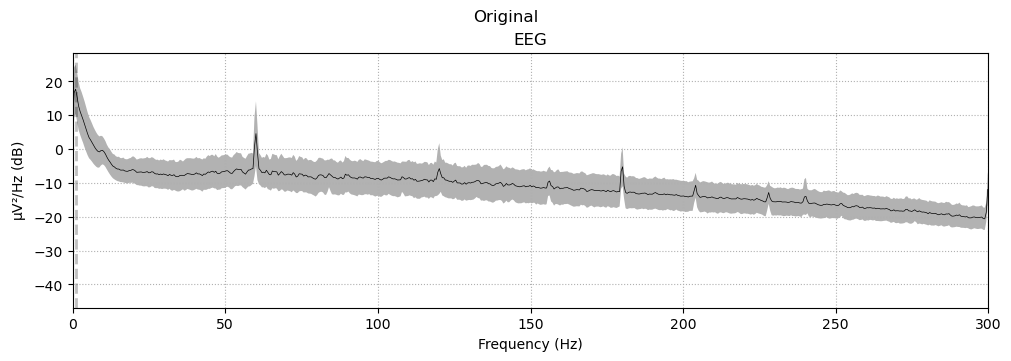

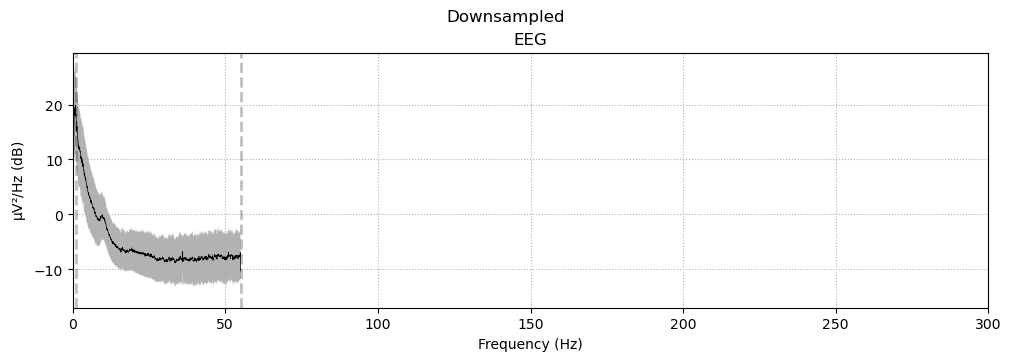

In [27]:
raw_downsampled = raw_data.copy().resample(sfreq=110)

for data, title in zip([raw_data, raw_downsampled], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="data", exclude="bads")
    fig.suptitle(title)
    plt.setp(fig.axes, xlim=(0, 300))

Fitting ICA to data using 63 channels (please be patient, this may take a while)


Selecting by number: 20 components
Fitting ICA took 9.3s.


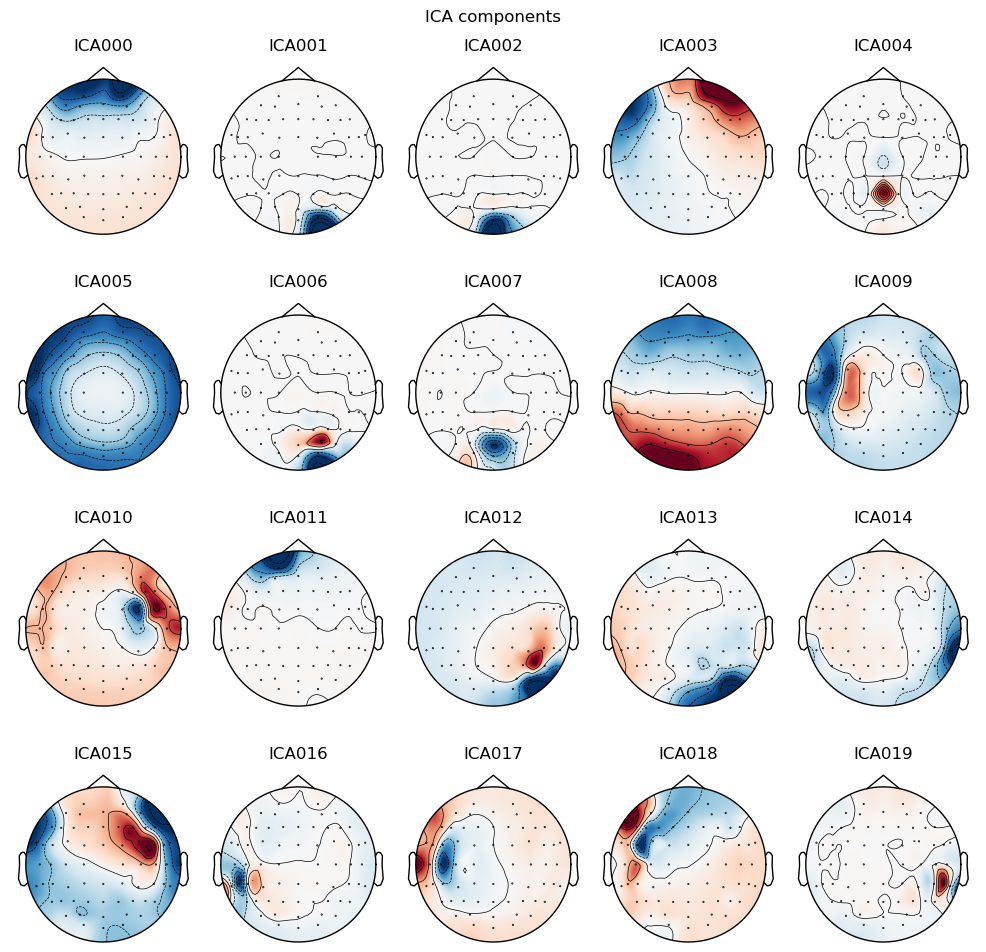

Creating RawArray with float64 data, n_channels=20, n_times=4258220
    Range : 0 ... 4258219 =      0.000 ...  4258.219 secs
Ready.


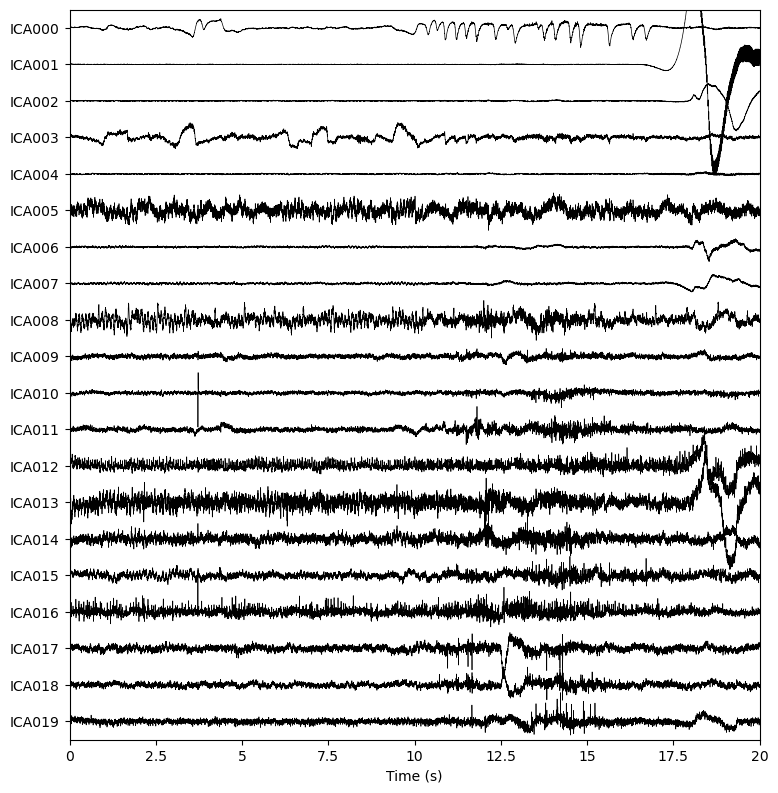

In [28]:
ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw_downsampled.copy())
ic_plot = ica.plot_components()
ic_plot = ica.plot_sources(raw_data, show_scrollbars=False)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2129 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2129 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2129 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2129 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2129 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2129 matching events found
No baseline correction applied
0 projection items activated


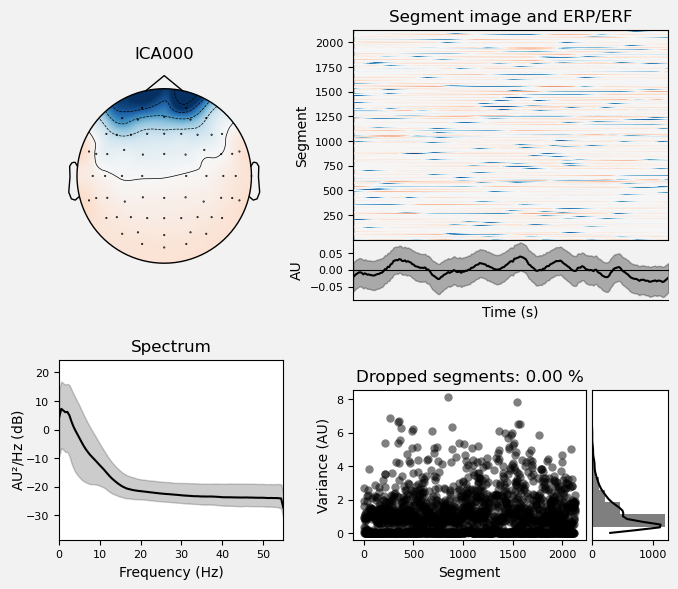

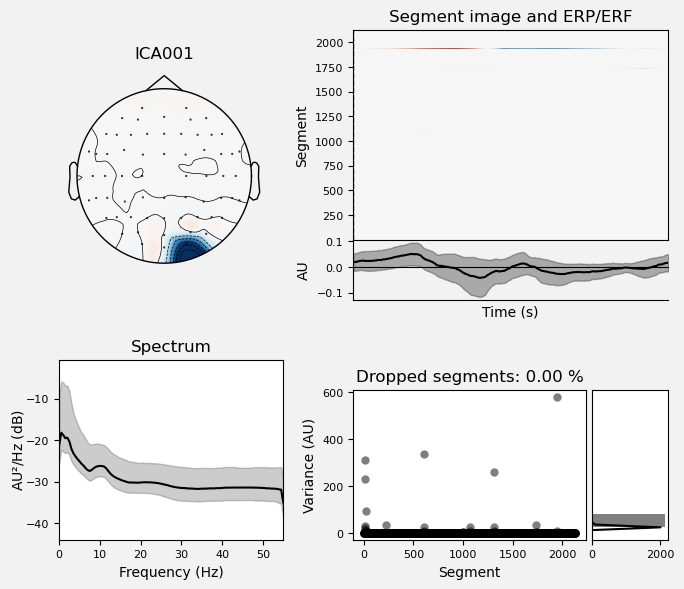

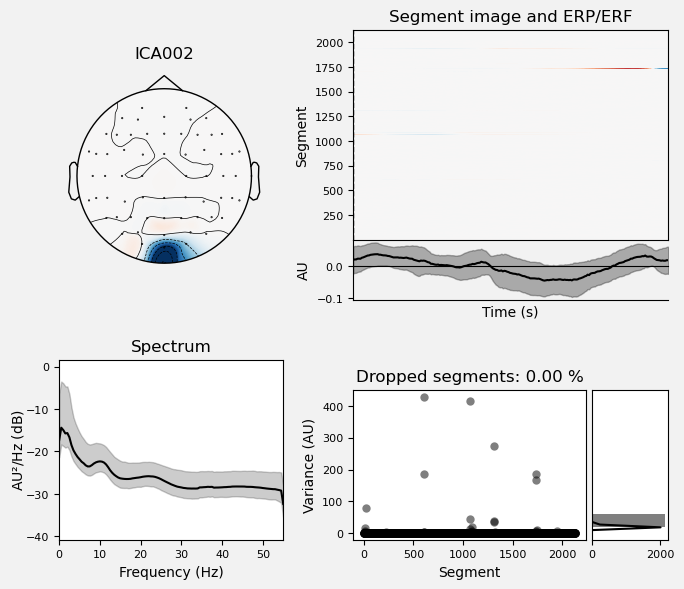

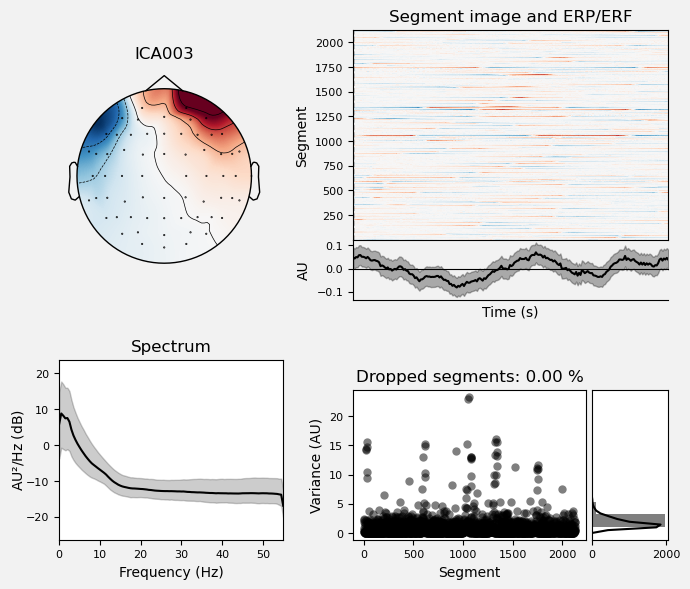

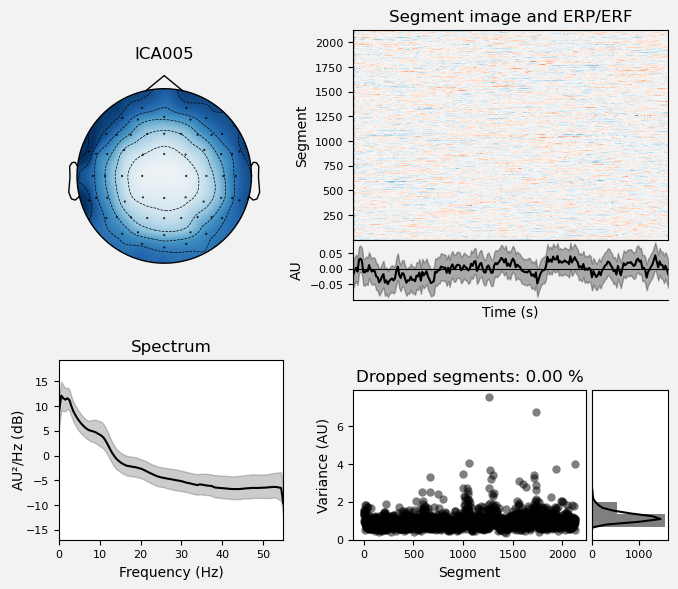

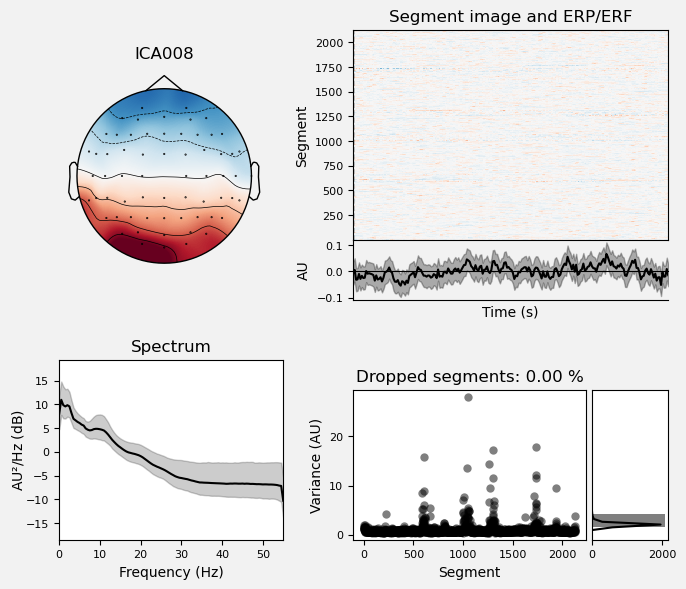

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [29]:
ica.plot_properties(raw_downsampled, picks=[0, 1, 2, 3, 5, 8])

In [42]:
ica.exclude = [0, 3]
#ica.plot_properties(raw_data, picks=ica.exclude)

In [34]:
events, _ = mne.events_from_annotations(raw_downsampled)
events_dict = {
    'blockonset': 1001,
    'blockend': 8,
    'fixation': 1,
    'delay1': 2,
    'delay2': 3,
    'response': 4,
    'feedback': 6,
    'iti': 7,
    'proinPF': 11,
    'prooutPF': 12,
    'antiinPF': 13,
    'antioutPF': 14
}
trl_events = {
    'proinPF': 11,
    'prooutPF': 12,
    'antiinPF': 13,
    'antioutPF': 14
}
#a = mne.viz.plot_events(events, first_samp=raw_data.first_samp, event_id=events_dict)

Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


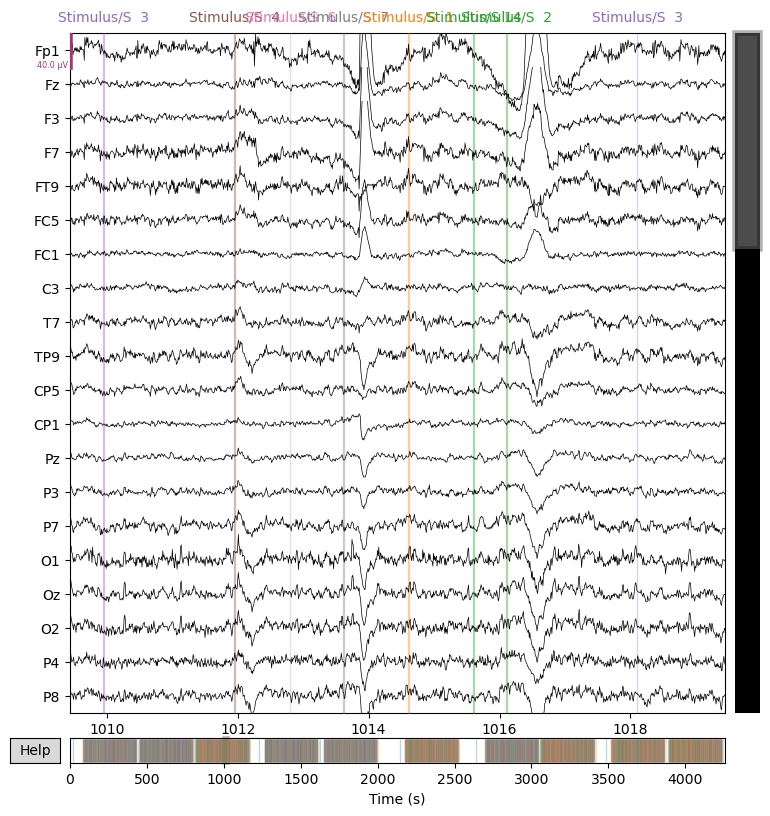

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


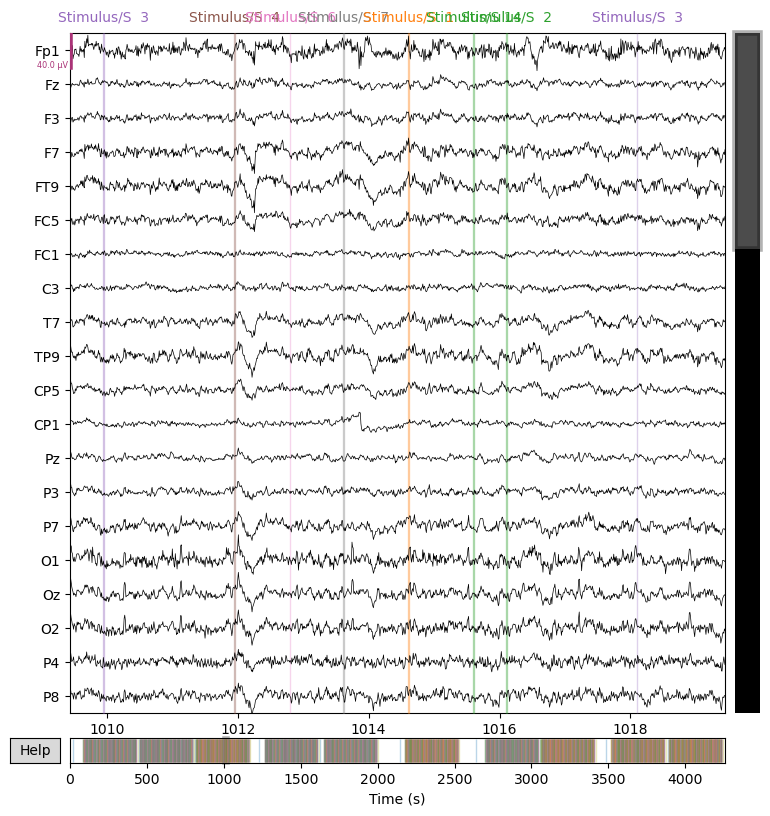

In [43]:
rr = raw_downsampled.plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=True)
rr = ica.apply(raw_downsampled.copy(), exclude=ica.exclude).plot(start=events[1, 0]/1000+1000, duration = 10, remove_dc=False)

Not setting metadata
400 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 606 original time points ...
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


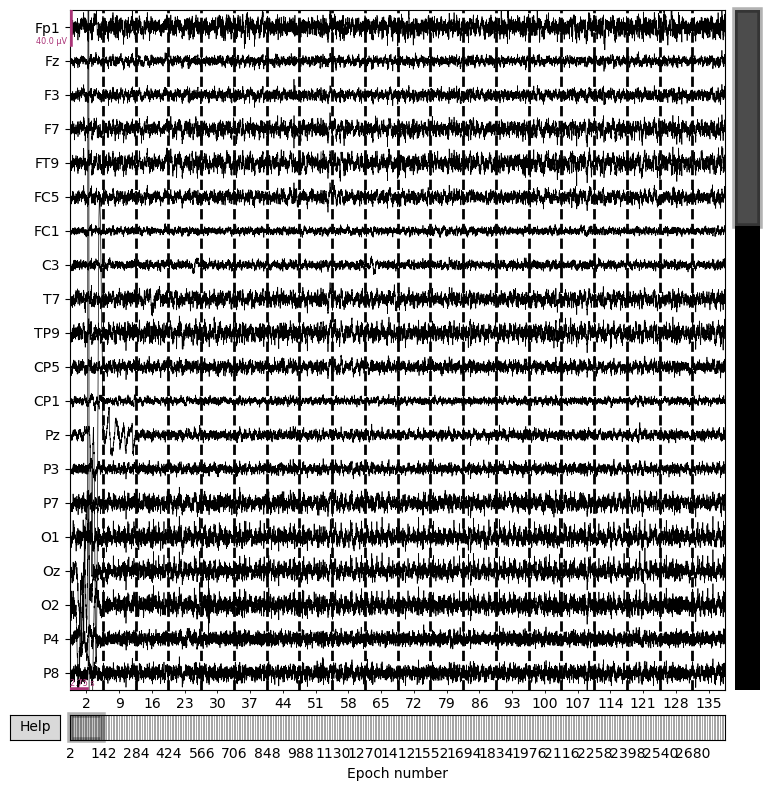

In [44]:
epoched_data = mne.Epochs(
    raw_downsampled, 
    events, 
    event_id=trl_events, 
    # tmin = -1.5,
    # tmax = 5.5,
    tmin=-1,
    tmax=4.5,
    baseline=None, 
    preload=True
)
epoched_data = ica.apply(epoched_data.copy(), exclude=ica.exclude)
b = epoched_data.plot()

In [45]:
proinPF = epoched_data['proinPF']
prooutPF = epoched_data['prooutPF']
antiinPF = epoched_data['antiinPF']
antioutPF = epoched_data['antioutPF']
proinPF_evoked = proinPF.average()
prooutPF_evoked = prooutPF.average()
antiinPF_evoked = antiinPF.average()
antioutPF_evoked = antioutPF.average()

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


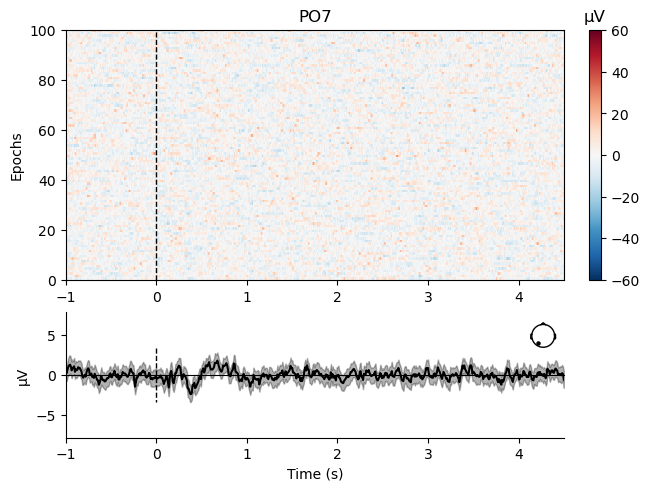

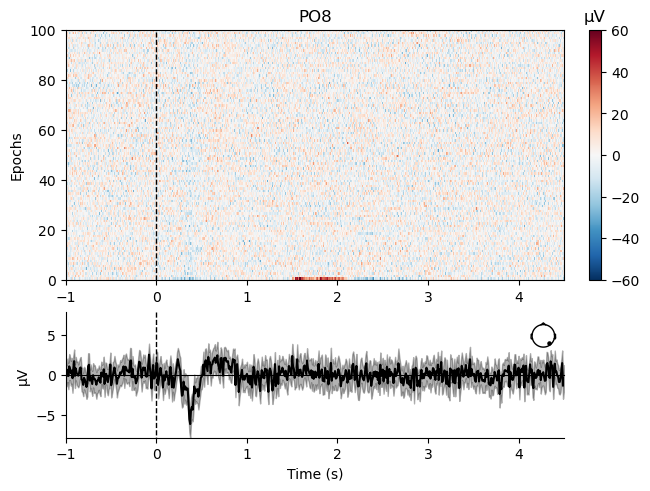

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [46]:
prooutPF.plot_image(picks=["PO7", "PO8"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    4.6s finished


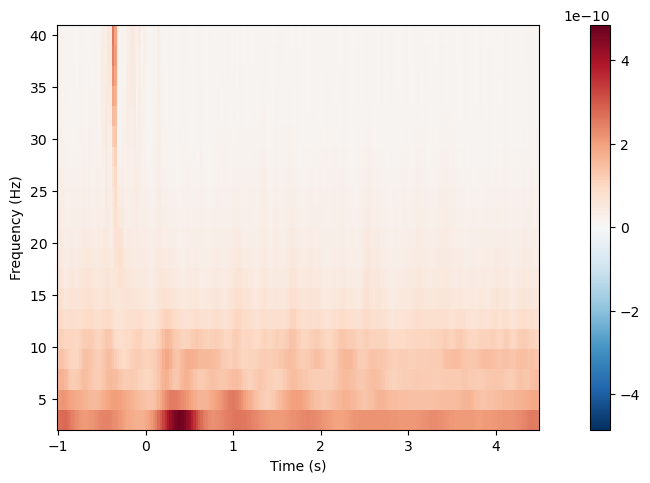

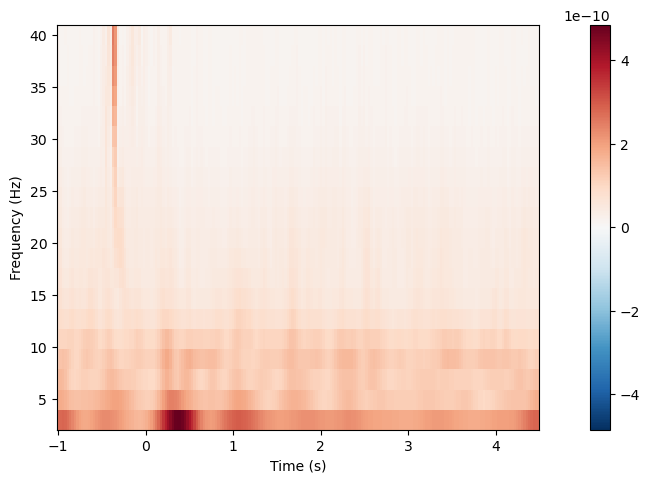

In [20]:
frequencies = np.linspace(3, 40, 20)
power = mne.time_frequency.tfr_morlet(
    proinPF, n_cycles=4, return_itc=False, freqs=frequencies, decim=3
)

aa = power.plot(["O1", "O2"])

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


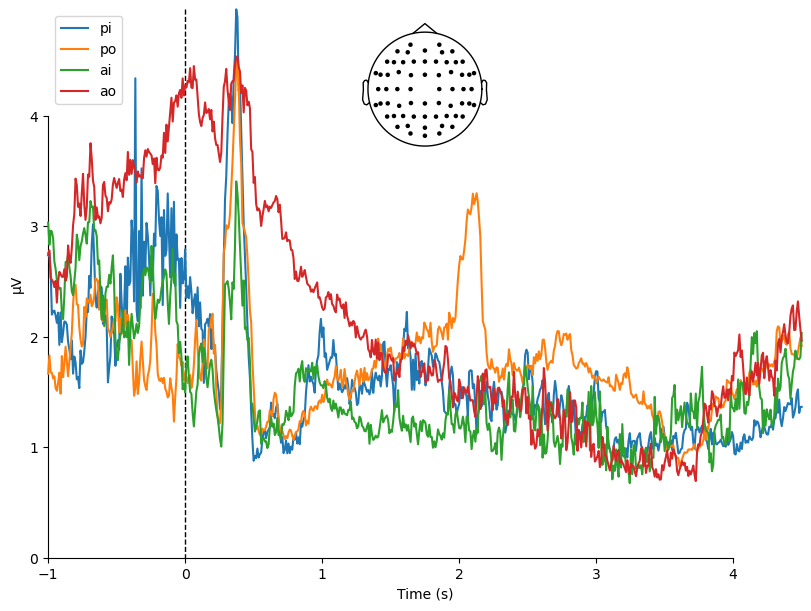

In [21]:
aa = mne.viz.plot_compare_evokeds(
    dict(pi=proinPF_evoked, po=prooutPF_evoked, ai=antiinPF_evoked, ao=antioutPF_evoked),
    legend="upper left",
    show_sensors="upper center"
)

In [ ]:
proinPF_evoked.plot_joint()